In [1]:
import os
import glob
import sys

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

np.random.seed(0)
%matplotlib inline

In [2]:
dir_name = '/home/isidro/Documents/github/model_independent_RC/data/MassModels/'
path = r'{}*.NFW.fix.REV.dat'.format(dir_name)
files = glob.glob(path)
print(files)

['/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2903.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3521.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC5055.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2841.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC7331.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC6946.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2366.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC925.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3621.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2403.NFW.fix.REV.dat', '/home/isidro/Documents/github/model_independent_RC/data/Mas

In [3]:
for i, file in enumerate(files):
    print(i, file)

0 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2903.NFW.fix.REV.dat
1 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3521.NFW.fix.REV.dat
2 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC5055.NFW.fix.REV.dat
3 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2841.NFW.fix.REV.dat
4 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC7331.NFW.fix.REV.dat
5 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC6946.NFW.fix.REV.dat
6 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2366.NFW.fix.REV.dat
7 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC925.NFW.fix.REV.dat
8 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3621.NFW.fix.REV.dat
9 /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2403.NFW.fix.REV.dat
10 /home/isidro/Documents/github/model_independent_RC/data/MassModels/N

In [4]:
files[11]

'/home/isidro/Documents/github/model_independent_RC/data/MassModels/DDO154.NFW.fix.REV.dat'

In [5]:
def dir_root_name(file):
    print(file)
#     print("dir name", dir_name)
#     s1 = file.rstrip(dir_name)
#     print("without dir", s1)
    s = file.rstrip('.NFW.fix.REV.dat')
    print("dir+root", s)
    return s

In [6]:
dir_root_name(files[11])

/home/isidro/Documents/github/model_independent_RC/data/MassModels/DDO154.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/DDO154


'/home/isidro/Documents/github/model_independent_RC/data/MassModels/DDO154'

Model 1/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2903.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2903
X_train shape: (69, 1) | y_train shape: (69, 2) | x_val shape: (18, 1) | y_val shape: (18, 2)
16/16 [==============================] - 0s 1ms/step
----------
Model 2/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3521.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3521
X_train shape: (80, 1) | y_train shape: (80, 2) | x_val shape: (20, 1) | y_val shape: (20, 2)
16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step
----------
Model 3/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC5055.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC5055
X_train shape: (159, 1) | y_train shape: (159, 2) | x_val shape: (40, 1) | y_val shape: (40, 2)
16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 1ms/step
----------
Model 4/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2841.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2841
X_train shape: (112, 1) | y_train shape: (112, 2) | x_val shape: (29, 1) | y_val shape: (29, 2)
16/16 [==============================] - 0s 1ms/step
----------
Model 5/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC7331.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC7331
X_train shape: (84, 1) | y_train shape: (84, 2) | x_val shape: (21, 1) | y_val shape: (21, 2)
16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 2ms/step
----------
Model 6/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC6946.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC6946
X_train shape: (165, 1) | y_train shape: (165, 2) | x_val shape: (42, 1) | y_val shape: (42, 2)
16/16 [==============================] - 0s 2ms/step


16/16 [==============================] - 0s 2ms/step
----------
Model 7/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2366.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2366
X_train shape: (32, 1) | y_train shape: (32, 2) | x_val shape: (9, 1) | y_val shape: (9, 2)
16/16 [==============================] - 0s 1ms/step
----------
Model 8/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC925.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC925
X_train shape: (76, 1) | y_train shape: (76, 2) | x_val shape: (20, 1) | y_val shape: (20, 2)
16/16 [==============================] - 0s 2ms/step


16/16 [==============================] - 0s 2ms/step
----------
Model 9/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3621.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3621
X_train shape: (98, 1) | y_train shape: (98, 2) | x_val shape: (25, 1) | y_val shape: (25, 2)
16/16 [==============================] - 0s 2ms/step


16/16 [==============================] - 0s 2ms/step
----------
Model 10/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2403.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2403
X_train shape: (230, 1) | y_train shape: (230, 2) | x_val shape: (58, 1) | y_val shape: (58, 2)
16/16 [==============================] - 0s 2ms/step
----------
Model 11/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3031.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3031
X_train shape: (93, 1) | y_train shape: (93, 2) | x_val shape: (24, 1) | y_val shape: (24, 2)
16/16 [==============================] - 0s 1ms/step


16/16 [==============================] - 0s 2ms/step
----------
Model 12/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/DDO154.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/DDO154
X_train shape: (48, 1) | y_train shape: (48, 2) | x_val shape: (13, 1) | y_val shape: (13, 2)
16/16 [==============================] - 0s 2ms/step


16/16 [==============================] - 0s 2ms/step
----------
Model 13/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2976.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC2976
X_train shape: (33, 1) | y_train shape: (33, 2) | x_val shape: (9, 1) | y_val shape: (9, 2)
16/16 [==============================] - 0s 2ms/step
----------
Model 14/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC4736.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC4736
X_train shape: (65, 1) | y_train shape: (65, 2) | x_val shape: (17, 1) | y_val shape: (17, 2)
16/16 [==============================] - 0s 2ms/step


16/16 [==============================] - 0s 4ms/step
----------
Model 15/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/IC2574.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/IC2574
X_train shape: (80, 1) | y_train shape: (80, 2) | x_val shape: (20, 1) | y_val shape: (20, 2)
16/16 [==============================] - 0s 2ms/step


16/16 [==============================] - 0s 1ms/step
----------
Model 16/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3198.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC3198
X_train shape: (75, 1) | y_train shape: (75, 2) | x_val shape: (19, 1) | y_val shape: (19, 2)
16/16 [==============================] - 0s 1ms/step
----------
Model 17/17
----------
/home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC7793.NFW.fix.REV.dat
dir+root /home/isidro/Documents/github/model_independent_RC/data/MassModels/NGC7793
X_train shape: (54, 1) | y_train shape: (54, 2) | x_val shape: (14, 1) | y_val shape: (14, 2)


16/16 [==============================] - 0s 1ms/step
----------


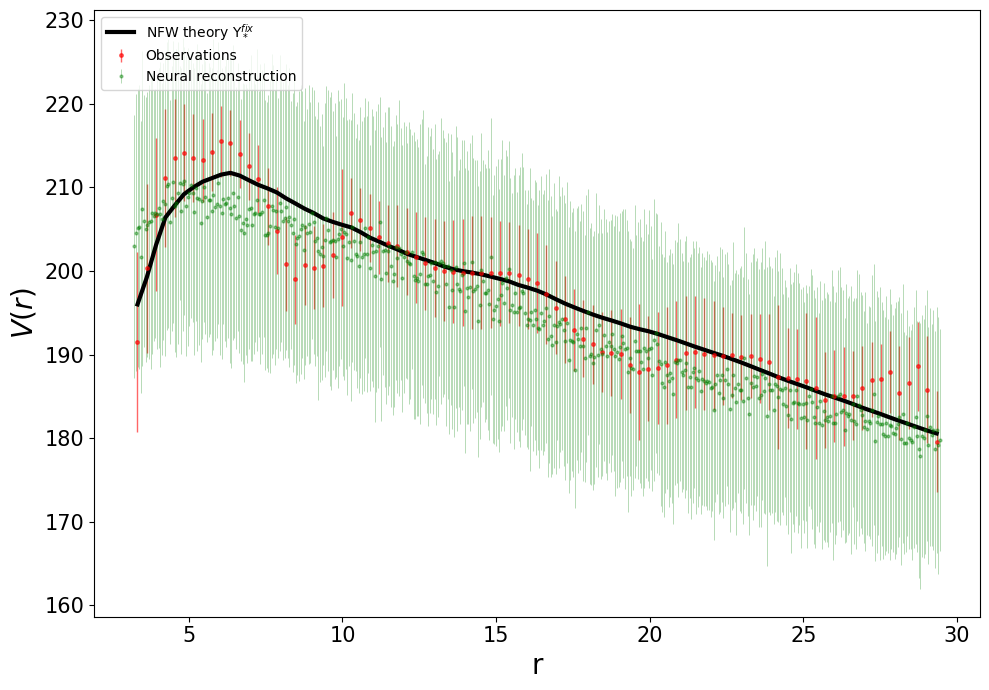

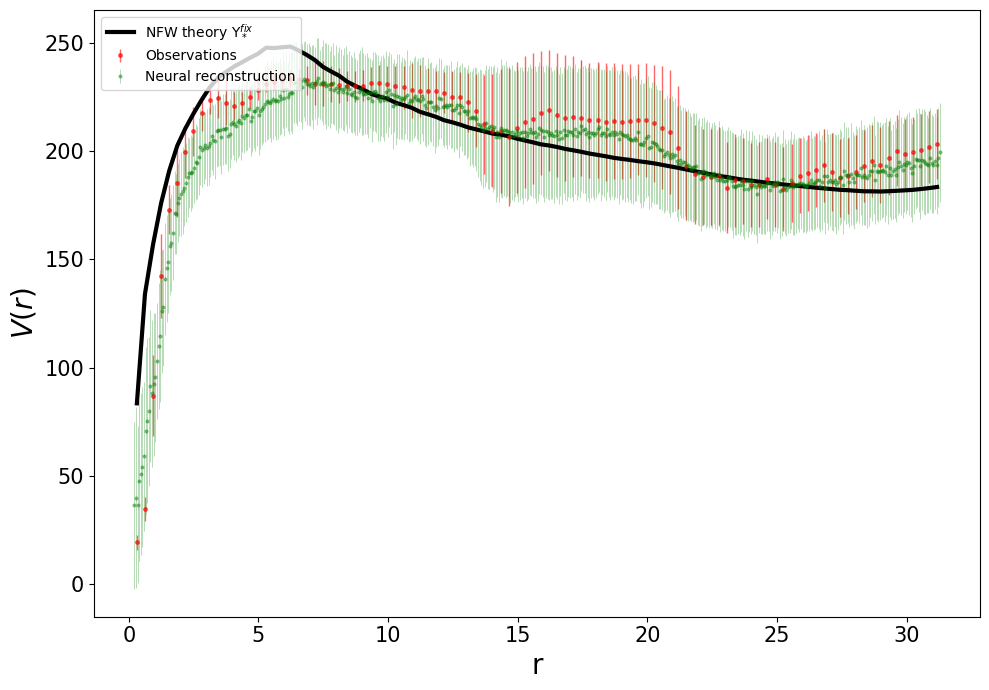

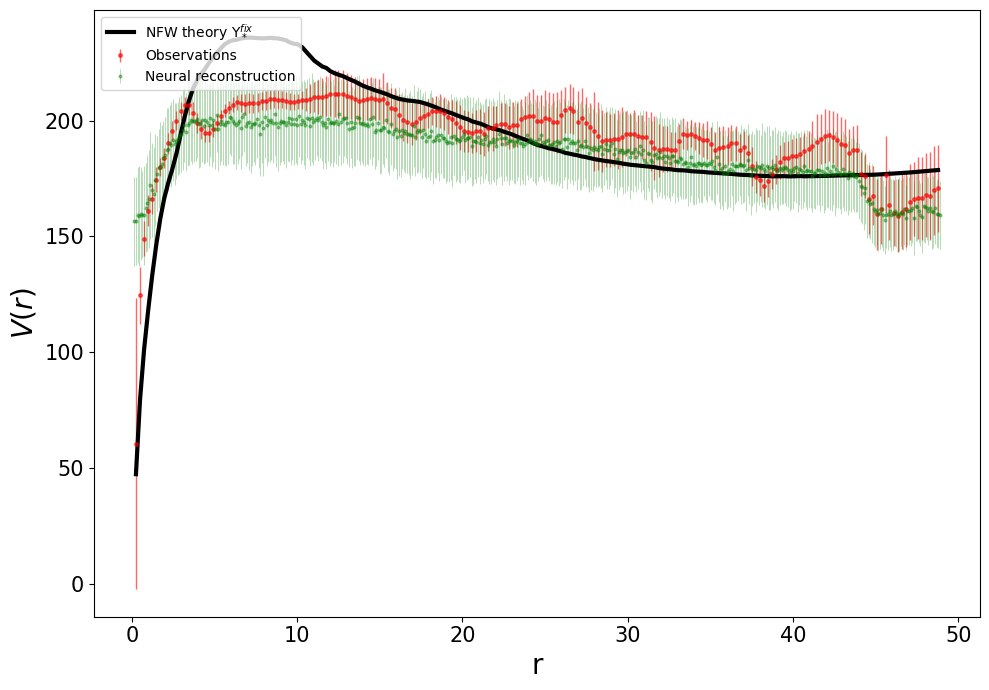

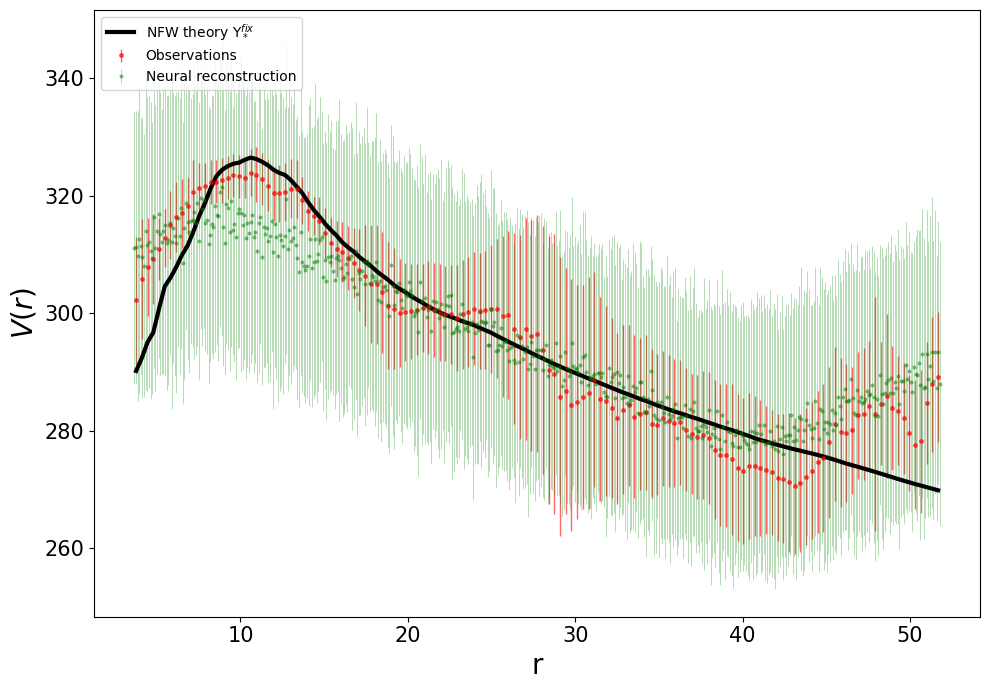

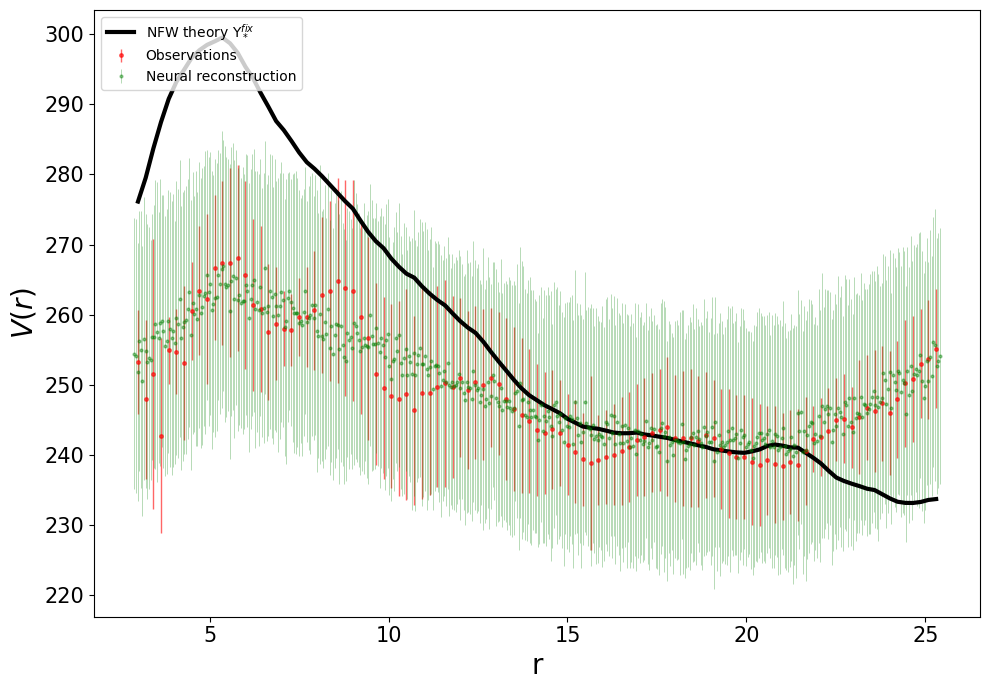

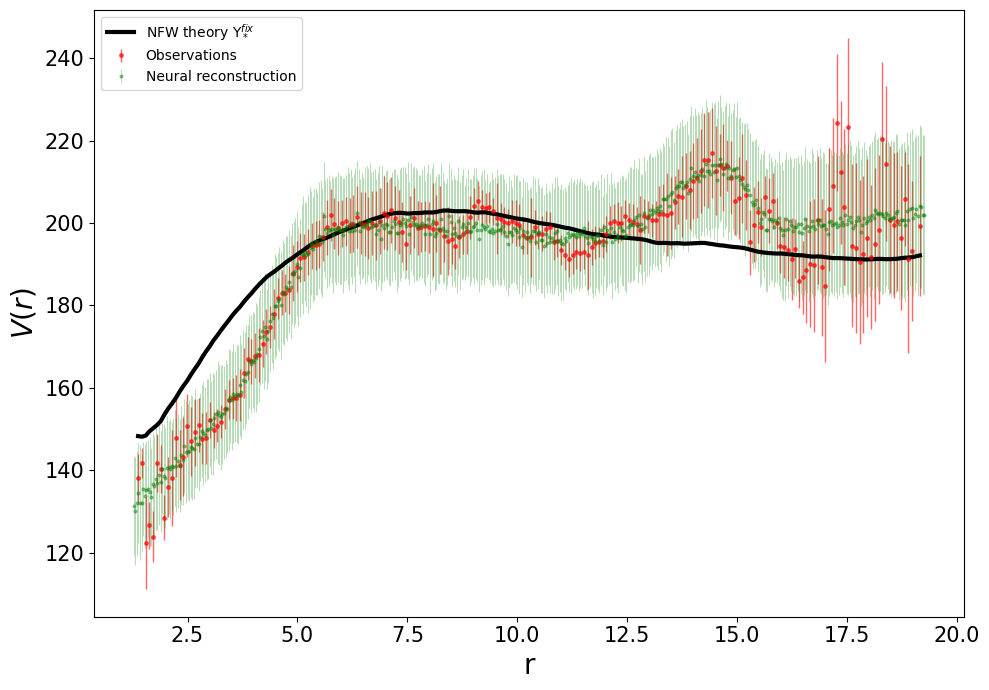

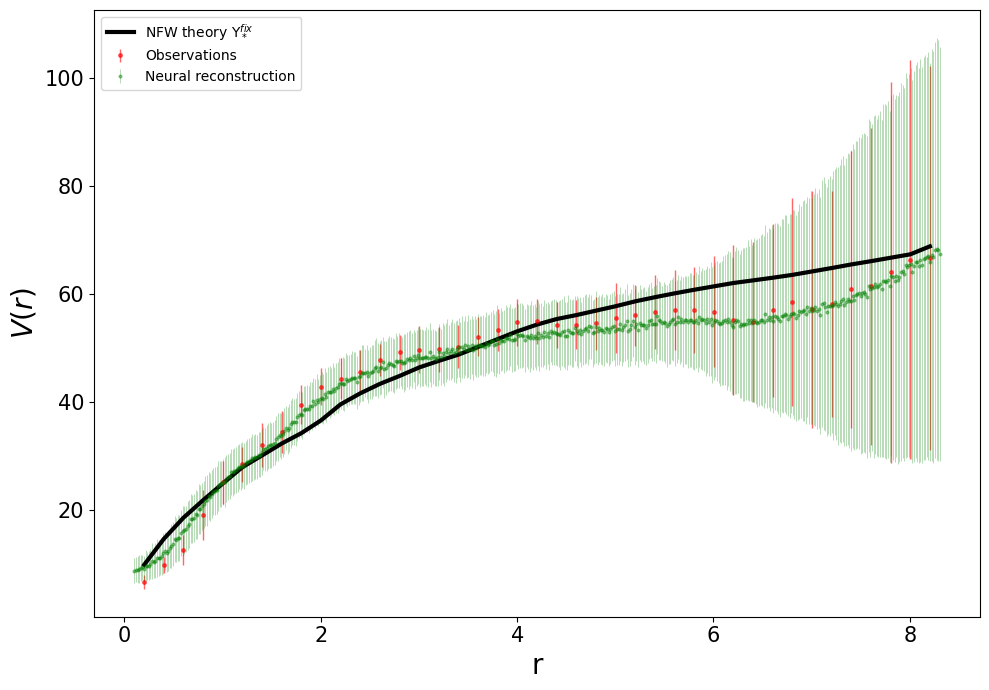

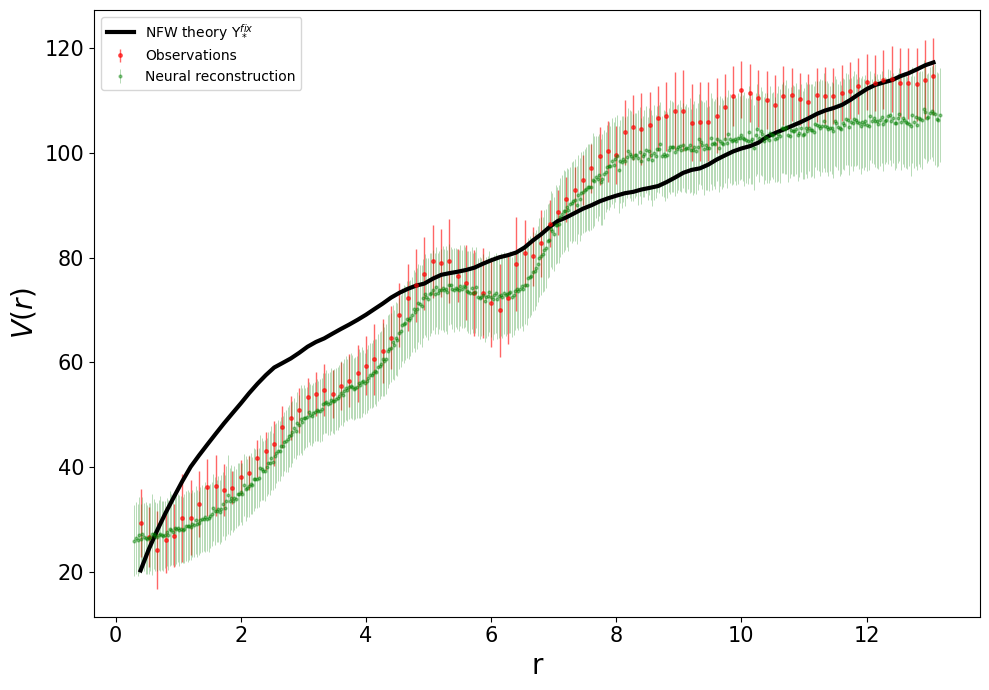

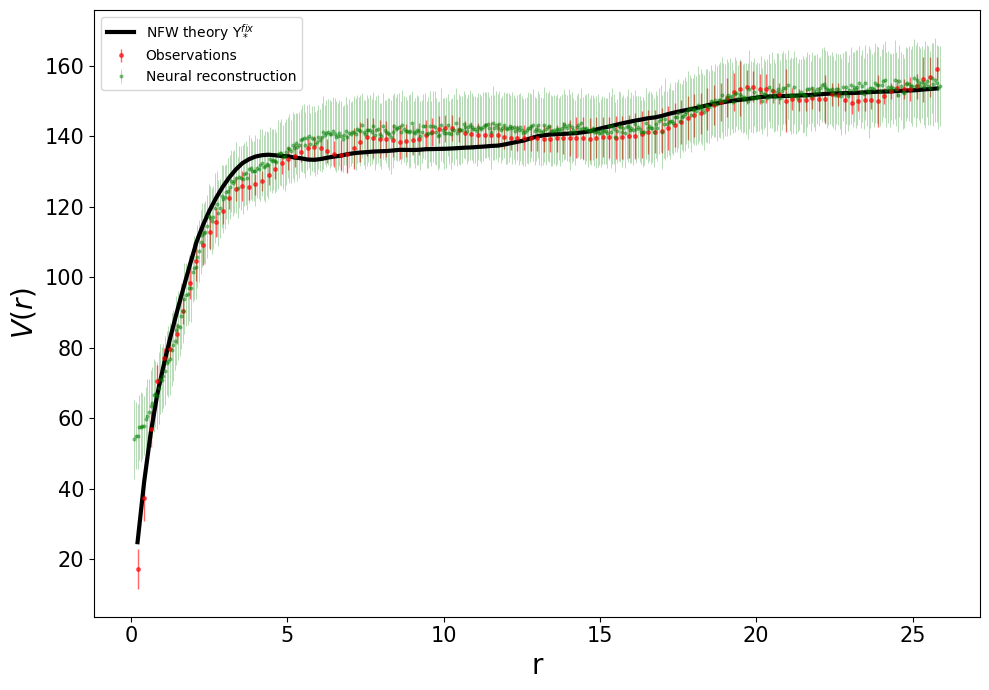

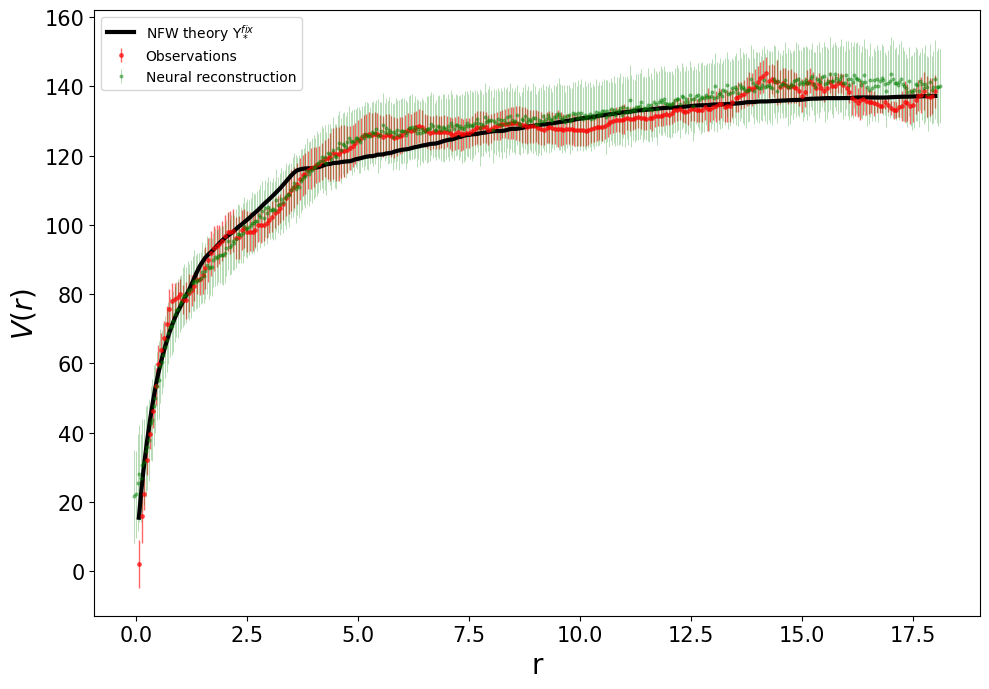

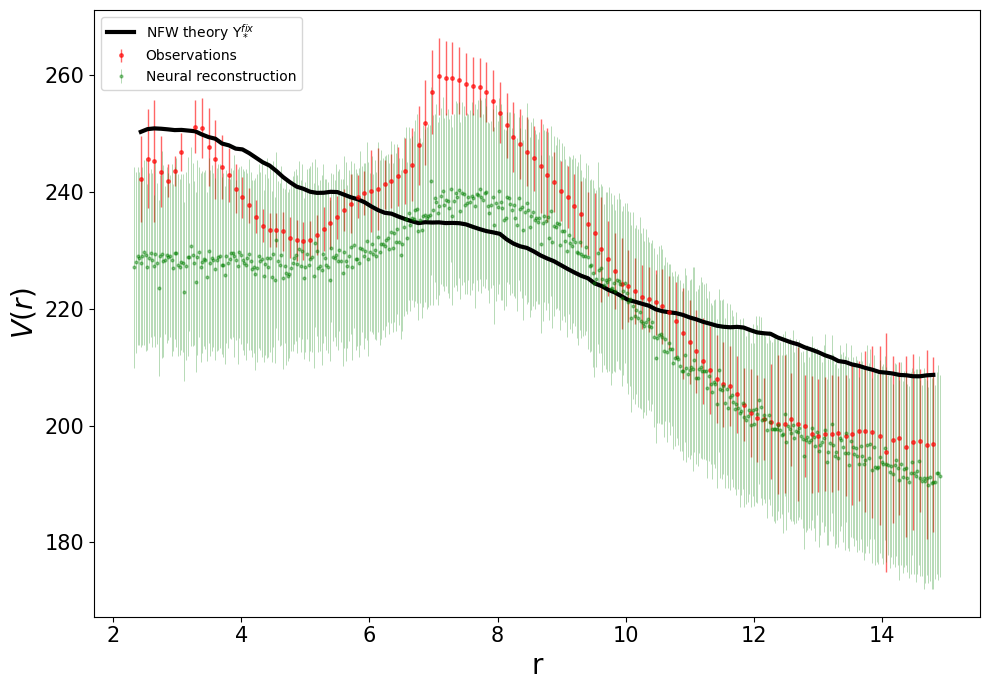

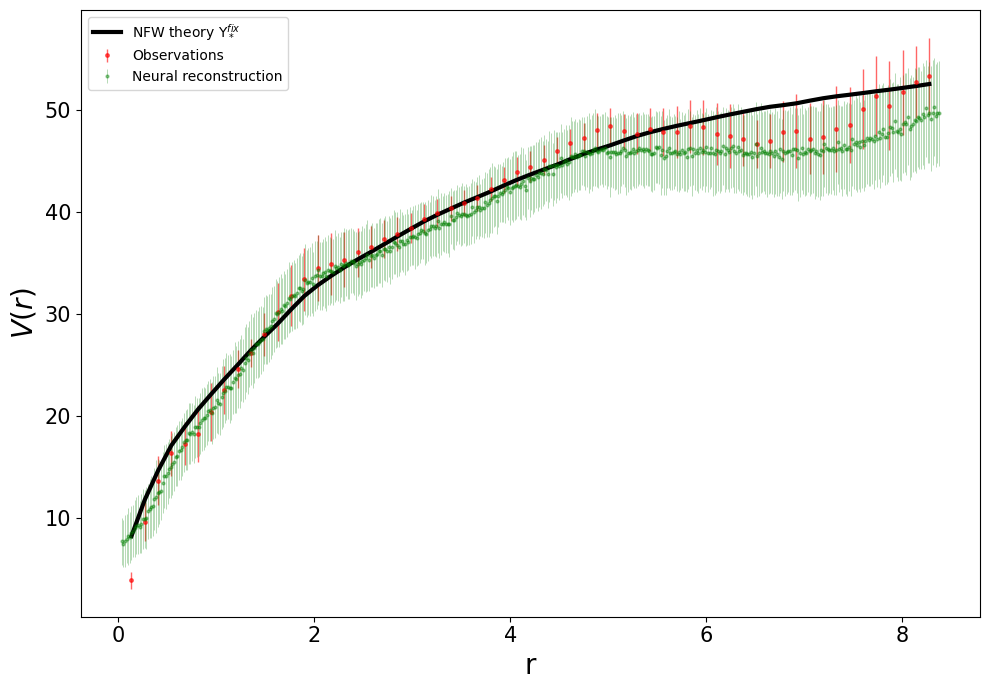

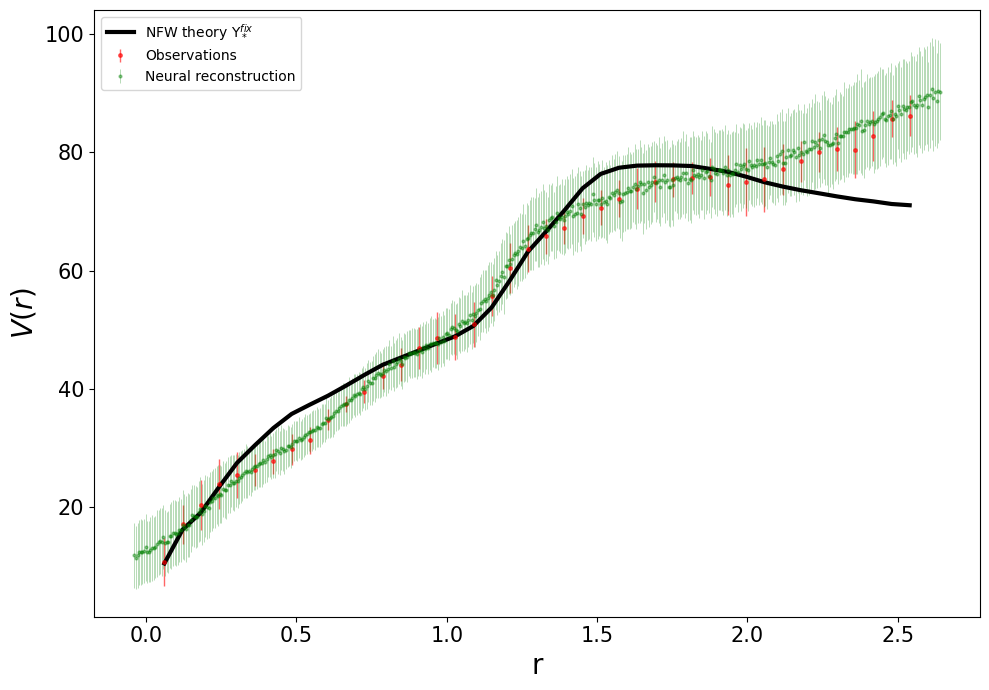

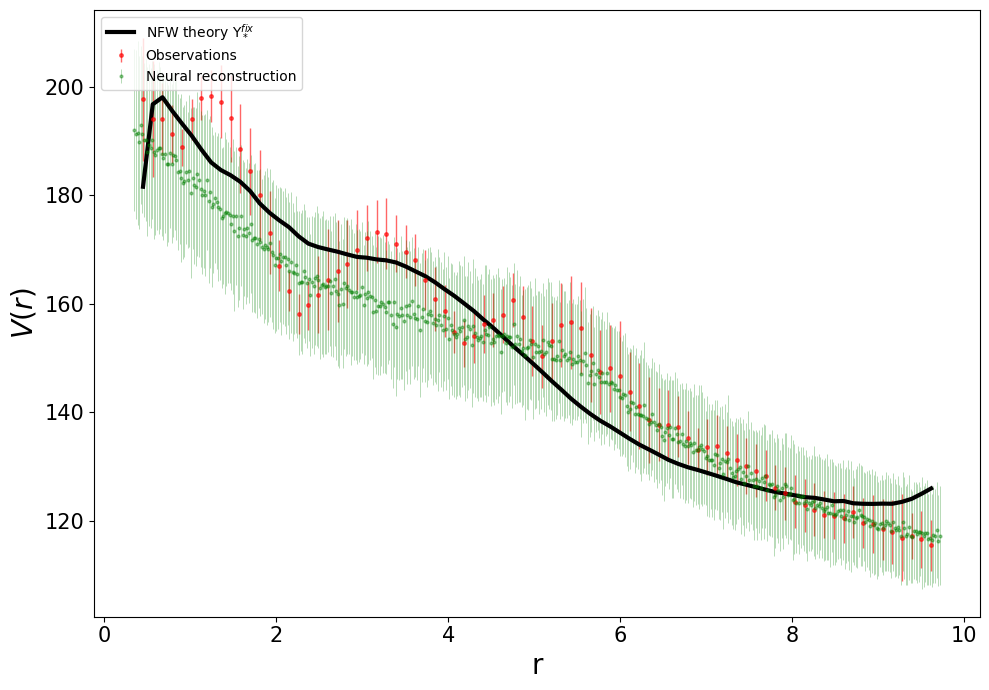

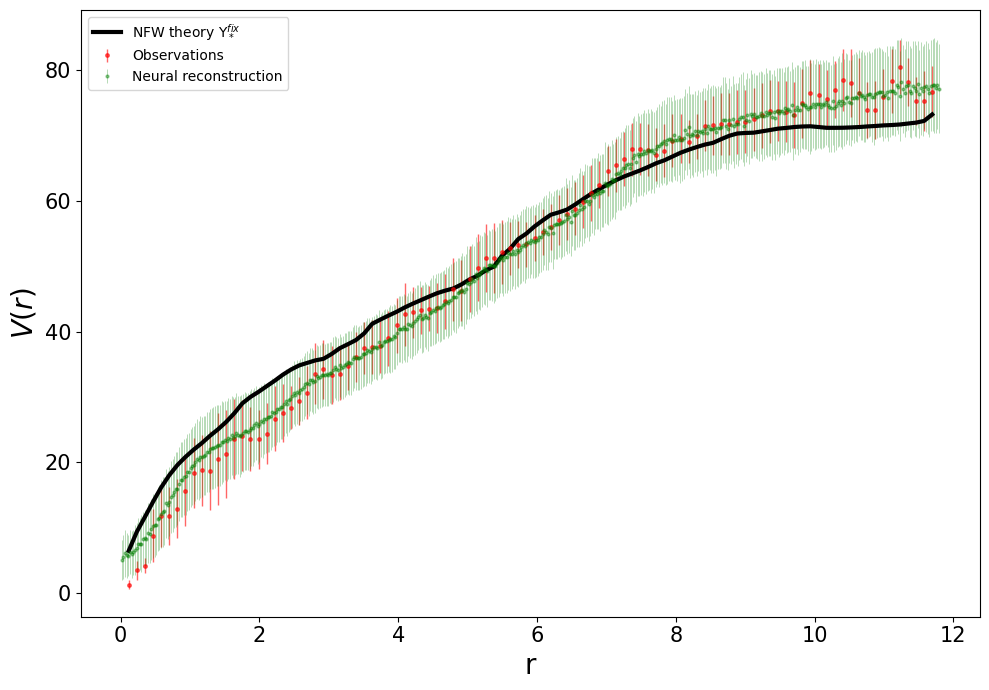

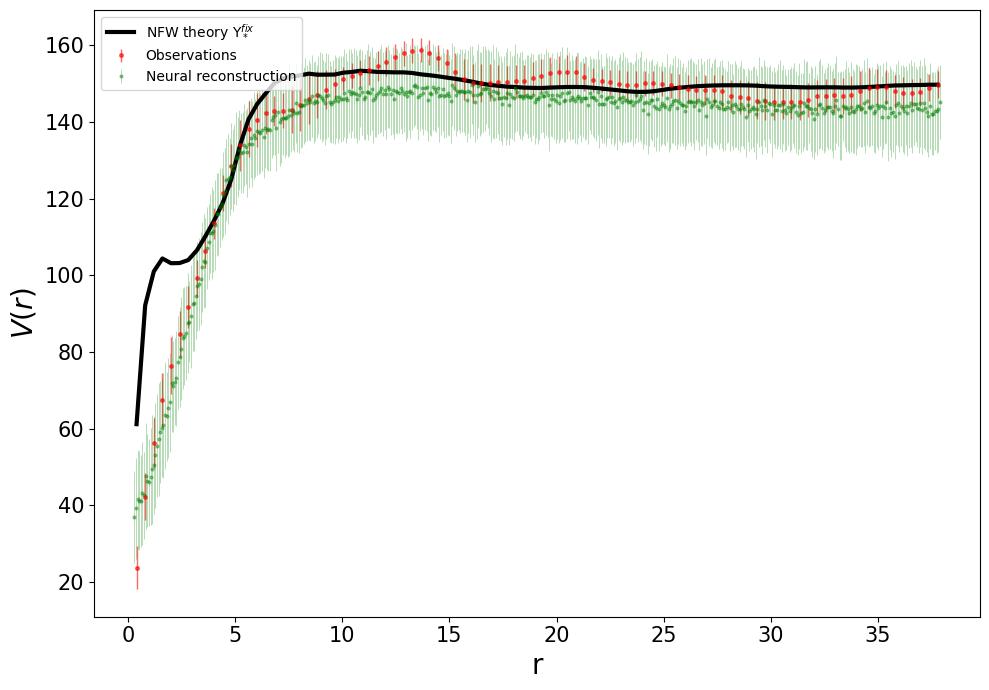

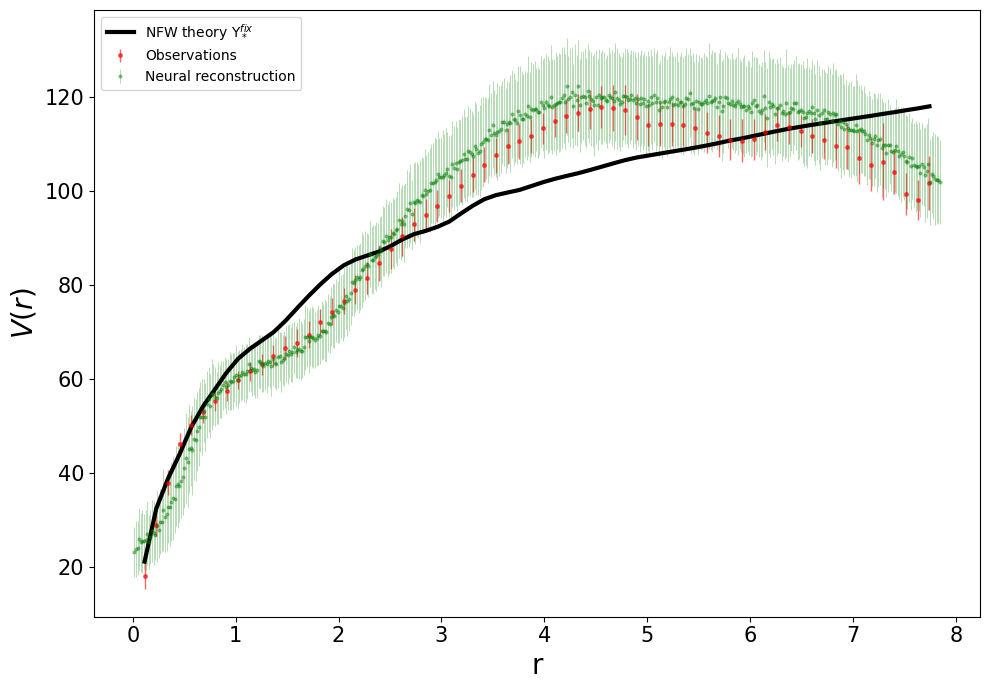

In [7]:
history_all = []
for idx, file in enumerate(files):
    print("Model {}/{}".format(idx+1, len(files)))
    print("-"*10)
    
    history_ind = {}
    
    data = np.loadtxt(files[idx], skiprows=12) 
    df = pd.DataFrame(data, columns=['Radius', 'vgas', 'vdisk', 'vbulge', 
                                     'vobs', 'err_vobs', 'Vu', 'Vt','Rxv', 'Vxy'])
    
    data_free = np.loadtxt(dir_root_name(files[idx])+".NFW.fix.REV.dat", skiprows=12)
    df_free = pd.DataFrame(data_free, columns=['Radius', 'vgas', 'vdisk', 'vbulge', 
                                     'vobs', 'err_vobs', 'Vu', 'Vt','Rxv', 'Vxy'])
    N = len(df.values)
    df = df[['Radius', 'vobs','err_vobs', 'Vt']]


    randomize = np.random.permutation(N)
    data = df.values[randomize]

    z = data[:,0]
    y = data[:,1:3]
    
    scalerz = StandardScaler()
    scalerz.fit(z.reshape(-1,1))
    # apply transform
    z = scalerz.transform(z.reshape(-1,1))
    
    split = 0.8
    ntrain = int(split * len(z))
    indx = [ntrain]
    z_train, z_test = np.split(z, indx)
    y_train, y_test = np.split(y, indx)
    
    print("X_train shape: {} | y_train shape: {} | x_val shape: {} | y_val shape: {}".format(np.shape(z_train), 
                                                                                             np.shape(y_train), 
                                                                                             np.shape(z_test), 
                                                                                             np.shape(y_test)))

        
    model = tf.keras.models.load_model('models/RC_model_{}.h5'.format(idx+1), custom_objects={'MCDropout': MCDropout})


    # Generate test data
    test_batch_size = 500
    # x_test = np.random.uniform(0, 2., test_batch_size)
    x_test = np.linspace(min(df['Radius'].values)-0.1, max(df['Radius'].values)+0.1, test_batch_size)

    mc_dropout_num = 100  # Run Dropout 100 times
    predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
    for i in range(mc_dropout_num):
        predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))

    # get mean results and its varience
    prediction_mc_dropout = np.mean(predictions, axis=0)
    std_mc_dropout = np.std(predictions, axis=0)
    
    # plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    overlapping = 0.6
    # Plotting
    plt.figure(figsize=(10, 7), dpi=100)
    sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

    plt.plot(df['Radius'].values, df['Vt'].values, color='black', linewidth=3, label='NFW theory $\\Upsilon_*^{fix}$',alpha=1)
    
#     plt.plot(df_free['Radius'].values, df_free['Vt'].values, color='blue', linewidth=3, label='NFW theory $\\Upsilon_*^{free}$', alpha=1)

    plt.errorbar(df['Radius'].values, df['vobs'].values, yerr=df['err_vobs'].values, fmt='.', 
                 color='red', elinewidth=1, ecolor='red', markersize=5, label='Observations', alpha=overlapping)

    plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
                 ecolor='green', capthick=2, elinewidth=0.5, alpha=overlapping-0.2, c='green',
                 label='Neural reconstruction')


    plt.ylabel("$V(r)$", fontsize=20)
    plt.xlabel("r", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.legend(loc='upper left')
    plt.tight_layout()

    plt.savefig("figures/load_neural_reconstruction_RC_{}.png".format(idx+1), dpi=100)
          
    print("-"*10)
    # plt.ylim(0, 200)